# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import warnings;warnings.filterwarnings("ignore")
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           import xarray as xr
import skill_metrics as sm;   import geopandas as gpd
import multiprocessing as mp
from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized
from sklearn.neighbors import BallTree
from scipy.stats import linregress

source $HOME/miniforge3/bin/activate


### Defined Functions

In [2]:
def noaa_data(begin,end,station,vdatum='NAVD',interval='6',
                       form='json',t_zone='GMT',unit='metric',product='water_level'):
    '''
      :param begin: begin date of the data
    :param end: end date of the data
    :param station: noaa station id
    :param vdatum: vertical datum such as NAVD
    :param interval: interval of the data (6 minutes)
    :param form: format of the data (json)
    :param t_zone: time zone of the data (GMT)
    :param unit: unit of the data (metric)
    :param product: type of the data (water_level)
    '''
    api = f'https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={begin}&end_date={end}&station={station}'\
         f'&product={product}&application=NOS.COOPS.TAC.WL&datum={vdatum}&interval={interval}&time_zone={t_zone}&units={unit}&format={form}'
    data = requests.get(url=api).content.decode()
    return data


def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def point_lookup(model_lat:np.array, model_lon:np.array, satellite_lat:np.array, satellite_lon:np.array):
    tree = BallTree(np.deg2rad(np.c_[model_lat,model_lon]), metric='haversine')
    distances, indices = tree.query(np.deg2rad(np.c_[satellite_lat, satellite_lon]), k = 1)
    return distances*6371,indices


#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

### Initialize path and read netcdf file

In [2]:
root = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/Processed_DATA')


In [3]:
def parse_dates_safe(date_str):
    try:
        return pd.to_datetime(date_str)
    except Exception:
        try:
            return pd.to_datetime(date_str, format='%Y-%b-%d')
        except Exception:
            return pd.NaT  # If still fails, set as missing

In [4]:
gdf = gpd.read_file('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/arctic_shapefiles/comm_and_flood/community+flood_wgs.shp')
gdf["flood_MSL"] = pd.to_numeric(gdf["flood_MSL"], errors="coerce")
gdf["CommunityKey"] = gdf["CommunityN"].str.strip().str.lower()
gdf["Date"] = gdf["Date"].apply(parse_dates_safe)
flood_lookup = gdf.set_index("CommunityKey")["flood_MSL"].to_dict()
id_lookup = gdf.set_index("CommunityKey")["CommunityI"].to_dict()
stage_lookup = gdf.set_index("CommunityKey")["NWS_Flood_"].to_dict()  # adjust column if different
date_lookup = gdf.set_index("CommunityKey")["Date"].to_dict()

In [25]:
years = ['2024','2023','2022','2021','2020','2019',
         '2018','2017','2016','2015','2014','2013','2012',
         '2011','2010','2009','2008','2007','2006',
         '2005','2004','2003','2002','2001','2000','1999']

# --- Container for results
exceedance_all = []
historic_all = []

for year in years:
    print(f"Processing year {year}...")
    ds = xr.open_dataset(root / f"{year}.nc")

    raw_names = ds["community"].values
    communities = [name.decode("utf-8").strip().lower() for name in raw_names]
    dt = pd.to_datetime(ds["time"].values)

    for node_idx, name_lc in enumerate(communities):
        if name_lc not in flood_lookup:
            continue

        flood_thresh = flood_lookup[name_lc]
        flood_stage = stage_lookup.get(name_lc, "Unknown")
        historic_date = date_lookup.get(name_lc, None)

        if pd.isna(flood_thresh) or flood_thresh == 0.0 or flood_thresh == -9999:
            continue
        if name_lc in ["chefornak", "tuntutuliak"]:
            continue

        depth = ds["depth"].values[0, node_idx]
        if np.isnan(depth) or depth > 0:
            continue

        wse = ds["zeta"].isel(node=node_idx).values
        wse = np.where(wse == -9999, np.nan, wse)
        wse = np.squeeze(wse)

        if wse.shape[0] != dt.shape[0]:
            print(f"Skipping node {node_idx}: mismatch in time series length")
            continue

        df = pd.DataFrame({"dt": dt, "WSE_Model": wse})
        df["Flood_Historic_MSL"] = flood_thresh
        df["Percent_of_Flood"] = (df["WSE_Model"] / flood_thresh) * 100
        df["Year"] = int(year)

        # Exceedances (≥95%)
        df_exceed = df[df["Percent_of_Flood"] >= 35].copy()
        if not df_exceed.empty:
            df_exceed["Community"] = name_lc.title()
            df_exceed["Flood_Stage_Label"] = flood_stage
            exceedance_all.append(df_exceed)

        # --- Check historic flood date ---
        if pd.notna(historic_date):
            # Find closest model timestamp (day resolution)
            idx = np.argmin(np.abs(df["dt"].values - np.datetime64(historic_date)))
            model_wse_historic = df.iloc[idx]["WSE_Model"]

            record = {
                "Community": name_lc.title(),
                "Historic_Date": historic_date,
                "Model_WSE_on_Historic_Date": model_wse_historic,
                "Historic_Flood_MSL": flood_thresh,
                "Flood_Stage_Label": flood_stage,
                "Year_Model_Data": int(year)
            }
            historic_all.append(record)

    ds.close()

# --- Combine outputs
df_exceed_all = pd.concat(exceedance_all, ignore_index=True)
df_historic_compare = pd.DataFrame(historic_all)

# Save exceedance flood days
df_exceed_all.to_csv("/scratch/tmiesse/project/model_data/all_community_flood_exceedances.csv", index=False)

# Save historic day comparisons
df_historic_compare.to_csv("/scratch/tmiesse/project/model_data/model_vs_historic_flood_days.csv", index=False)

# --- Also save the summary
summary = (
    df_exceed_all
    .drop_duplicates(subset=["Community", "Year", "dt"])
    .groupby(["Community", "Year"])
    .size()
    .reset_index(name="Unique Flood Days")
)

summary.to_csv("/scratch/tmiesse/project/model_data/flood_historic_summary_unique_days.csv", index=False)

Processing year 2024...
Processing year 2023...
Processing year 2022...
Processing year 2021...
Processing year 2020...
Processing year 2019...
Processing year 2018...
Processing year 2017...
Processing year 2016...
Processing year 2015...
Processing year 2014...
Processing year 2013...
Processing year 2012...
Processing year 2011...
Processing year 2010...
Processing year 2009...
Processing year 2008...
Processing year 2007...
Processing year 2006...
Processing year 2005...
Processing year 2004...
Processing year 2003...
Processing year 2002...
Processing year 2001...
Processing year 2000...
Processing year 1999...


In [9]:

exceedance_all = []
historic_comparisons = []

# --- Loop over all years ---
for year in years:
    print(f"Processing year {year}...")
    ds = xr.open_dataset(root / f"{year}.nc")

    raw_names = ds["community"].values
    communities = [name.decode("utf-8").strip().lower() for name in raw_names]
    dt = pd.to_datetime(ds["time"].values)

    for node_idx, name_lc in enumerate(communities):
        if name_lc not in flood_lookup:
            continue

        flood_thresh = flood_lookup[name_lc]
        flood_stage = stage_lookup.get(name_lc, "Unknown")
        historic_date = pd.to_datetime(date_lookup.get(name_lc, None), errors="coerce")

        # --- Validity checks ---
        if pd.isna(flood_thresh) or flood_thresh == 0.0:
            continue
        if name_lc in ["chefornak", "tuntutuliak"]:
            continue
        #depth_val = ds["depth"].isel(node=node_idx).values
        #if np.isnan(depth_val) or depth_val > 0:
        #    continue

        # --- Extract water surface elevation (WSE) ---
        wse = ds["zeta"].isel(node=node_idx).values
        wse = np.where(wse == -9999, np.nan, wse)
        wse = np.squeeze(wse)

        if wse.shape[0] != dt.shape[0]:
            print(f"Skipping node {node_idx}: shape mismatch")
            continue

        df = pd.DataFrame({"dt": dt, "WSE_Model": wse})
        df["Flood_Historic_MSL"] = flood_thresh
        df["Percent_of_Flood"] = (df["WSE_Model"] / flood_thresh) * 100
        df["Year"] = int(year)

        # --- Step 1: Record exceedances (≥95%) ---
        df_exceed = df[df["Percent_of_Flood"] >= 85].copy()
        if not df_exceed.empty:
            df_exceed["Community"] = name_lc.title()
            df_exceed["Flood_Stage_Label"] = flood_stage
            exceedance_all.append(df_exceed)

        # --- Step 2: Historic event comparison ---
        if pd.notna(historic_date):
            # Match model date to historic date (at daily level)
            df["date_only"] = df["dt"].dt.date
            match_idx = df["date_only"] == historic_date.date()
            if match_idx.any():
                best_idx = df.loc[match_idx, "WSE_Model"].idxmax()
                model_wse_historic = df.loc[best_idx, "WSE_Model"]
                model_date_historic = df.loc[best_idx, "dt"]

                record = {
                    "Community": name_lc.title(),
                    "Historic_Date": historic_date,
                    "Model_Date_Closest": model_date_historic,
                    "Model_WSE_at_Historic": model_wse_historic,
                    "Historic_MSL_WSE": flood_thresh,
                    "Flood_Stage_Label": flood_stage,
                    "Year_Model_Data": int(year)
                }
                historic_comparisons.append(record)

    ds.close()

# --- Save Results ---
print("Saving outputs...")

# Full flood exceedance database
df_exceed_all = pd.concat(exceedance_all, ignore_index=True)
df_exceed_all.to_csv("/scratch/tmiesse/project/model_data/all_community_flood_exceedances.csv", index=False)

# Unique flood days summary
summary = (
    df_exceed_all
    .drop_duplicates(subset=["Community", "Year", "dt"])
    .groupby(["Community", "Year"])
    .size()
    .reset_index(name="Unique Flood Days")
)
summary.to_csv("/scratch/tmiesse/project/model_data/flood_historic_summary_unique_days.csv", index=False)

# Historic flood comparison database
df_historic_compare = pd.DataFrame(historic_comparisons)
df_historic_compare.to_csv("/scratch/tmiesse/project/model_data/historic_flood_comparison_model_vs_observed.csv", index=False)


Processing year 2024...
Processing year 2023...
Processing year 2022...
Processing year 2021...
Processing year 2020...
Processing year 2019...
Processing year 2018...
Processing year 2017...
Processing year 2016...
Processing year 2015...
Processing year 2014...
Processing year 2013...
Processing year 2012...
Processing year 2011...
Processing year 2010...
Processing year 2009...
Processing year 2008...
Processing year 2007...
Processing year 2006...
Processing year 2005...
Processing year 2004...
Processing year 2003...
Processing year 2002...
Processing year 2001...
Processing year 2000...
Processing year 1999...
Saving outputs...


In [26]:
gdf = gpd.read_file('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/arctic_shapefiles/comm_and_flood/community+flood_wgs.shp')
gdf["flood_MSL"] = pd.to_numeric(gdf["flood_MSL"], errors="coerce")
gdf["CommunityKey"] = gdf["CommunityN"].str.strip().str.lower()

# --- Load flood summary CSV ---
summary = pd.read_csv("/scratch/tmiesse/project/model_data/flood_historic_summary_unique_days.csv")
summary["CommunityKey"] = summary["Community"].str.strip().str.lower()

# --- Aggregate total flood days across all years ---
summary_total = summary.groupby("CommunityKey")["Unique Flood Days"].sum().reset_index(name="Total Days")

# --- Merge flood summary with shapefile ---
gdf_plot = gdf.merge(summary_total, on="CommunityKey", how="left").fillna({"Total Days": 0})
gdf_plot["centroid"] = gdf_plot.geometry.centroid

In [27]:
bins = [0, 1, 2, 3, 4, 5, 6]  # now 6 intervals
labels = ["0", "1–2", "2–3", "3–4", "4–5", "5+"]  # match 6 bins
cmap = plt.get_cmap("YlOrRd", len(bins) - 1)
norm = mpl.colors.BoundaryNorm(bins, ncolors=cmap.N)

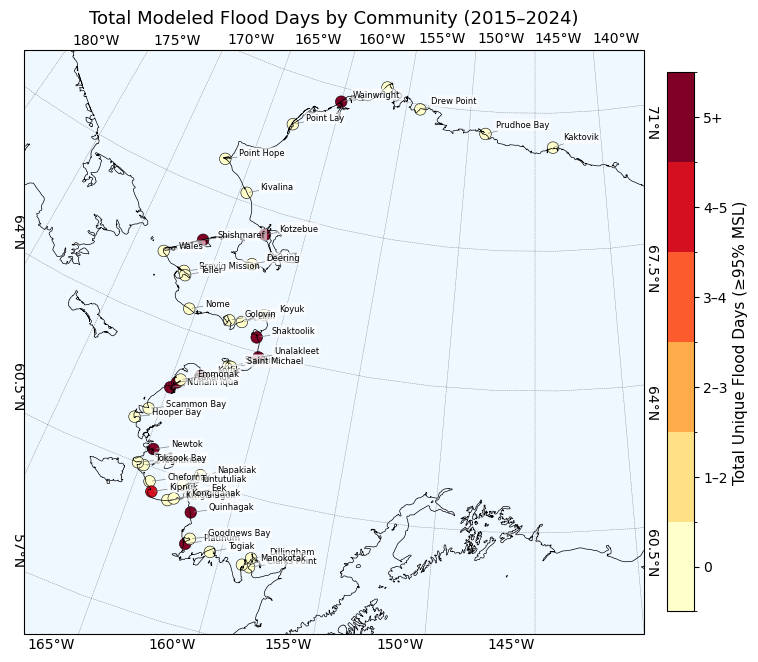

In [28]:
lat1, lat2 = 58, 71
lon1, lon2 = -169, -140

fig = plt.figure(figsize=(8, 8))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
ax = plt.axes(projection=proj)
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())

# --- Base map features ---
ax.add_feature(cart.feature.LAND, facecolor="lightgray")
ax.add_feature(cart.feature.OCEAN, facecolor="aliceblue")
ax.coastlines(resolution="10m", linewidth=0.5)

gl = ax.gridlines(xlocs=np.arange(-190, -100, 5),
                  ylocs=np.arange(-90, 90, 3.5),
                  draw_labels=True, linewidth=0.3, color="black", alpha=0.5,
                  y_inline=False, linestyle="--", zorder=20)
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.xlabel_style = {'rotation': 0}
gl.ylabels_left = False
gl.ylabels_right = True
gl.ylabel_style = {'rotation': -90}
gl.ypadding = 1.25
gl.xformatter = cart.mpl.gridliner.LONGITUDE_FORMATTER
gl.xpadding = 8

# --- Community points with discrete coloring ---
sc = ax.scatter(
    gdf_plot["centroid"].x, gdf_plot["centroid"].y,
    c=gdf_plot["Total Days"],
    cmap=cmap, norm=norm,
    s=70, edgecolor="black", linewidth=0.4,
    transform=ccrs.PlateCarree()
)

# --- Annotate community names with arrowed labels ---
for idx, row in gdf_plot.iterrows():
    x = row["centroid"].x
    y = row["centroid"].y
    dx, dy = 0.75, 0.25  # Offsets

    if not (lon1 <= x <= lon2 and lat1 <= y <= lat2):
        continue

    ax.annotate(
        row["CommunityN"],
        xy=(x, y),
        xytext=(x + dx, y + dy),
        textcoords=ccrs.PlateCarree()._as_mpl_transform(ax),
        fontsize=6,
        arrowprops=dict(
            arrowstyle="-", color="gray", lw=0.5,
            shrinkA=0, shrinkB=2
        ),
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.6),
        ha="left", va="center",
        zorder=25,
        transform=ccrs.PlateCarree()
    )

# --- Discrete colorbar ---
tick_locs = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]
cbar = plt.colorbar(
    sc, ax=ax, orientation="vertical",
    boundaries=bins, ticks=tick_locs,
    spacing='proportional', shrink=0.7, pad=0.03
)
cbar.set_label("Total Unique Flood Days (≥95% MSL)", fontsize=11)
cbar.ax.set_yticklabels(labels)

plt.title("Total Modeled Flood Days by Community (2015–2024)", fontsize=13)
plt.tight_layout()
plt.show()